In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
import h5py
import yaml
from ticker_download_manager import TickerDownloadManager
from date_manager import DateManager
from ticker_predict_upload import TickerPredictUpload
from s3_uploader import S3Uploader

In [2]:
tdm = TickerDownloadManager(os.path.join("input", "annual"))
dm = DateManager()
tpu = TickerPredictUpload()

### Get the past year of ticker close prices

In [3]:
long_df, start_date, end_date = tdm.get_latest_tickers(days_in_past=252, use_cache=True)
print(f"{start_date} to {end_date}")
long_df

2024-05-28 23:59:59 to 2025-05-30 23:59:59


,datetime,ticker,open,high,low,close,volume,vwap,transactions
0,2024-05-28 23:59:59,XBI,90.680,90.940,88.195,89.130,9042156.0,89.0615,96943
1,2024-05-28 23:59:59,VOO,487.400,487.645,484.525,487.120,4034716.0,486.6112,162555
2,2024-05-28 23:59:59,NVDA,110.244,114.939,109.883,113.901,652354890.0,112.6298,1706145
3,2024-05-28 23:59:59,VXUS,61.860,61.919,61.435,61.620,3560778.0,61.6378,17216
4,2024-05-28 23:59:59,QQQ,459.180,459.740,456.690,459.680,26180815.0,458.6121,251917
...,...,...,...,...,...,...,...,...,...
2487,2025-05-30 23:59:59,VOO,541.350,543.390,536.160,541.760,6166751.0,540.7254,180519
2488,2025-05-30 23:59:59,XLE,81.630,81.955,80.875,81.530,15508549.0,81.4804,116584
2489,2025-05-30 23:59:59,QQQ,519.440,520.680,511.930,519.110,67650900.0,517.3060,792605
2490,2025-05-30 23:59:59,NVDA,138.715,139.620,132.920,135.130,333334039.0,135.4876,2308757


### Pivot the close prices for better analysis

In [4]:
wide_df = tpu.pivot_ticker_close_wide(long_df)
date_from = wide_df.index[0]
date_to = wide_df.index[-1]
wide_df

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
2024-05-28 17:00:00,NaN,100.3746,218.19,38.98,113.901,459.68,487.12,61.62,89.13,92.31
2024-05-29 17:00:00,NaN,99.8204,216.16,38.32,114.825,456.44,483.69,60.59,87.48,90.68
2024-05-30 17:00:00,NaN,100.0905,216.57,39.16,110.500,451.55,480.44,60.97,88.96,90.94
2024-05-31 17:00:00,NaN,100.2900,215.30,38.55,109.633,450.71,484.62,61.27,89.13,93.20
2024-06-03 17:00:00,NaN,100.5600,217.22,39.44,115.000,453.13,485.15,61.53,91.42,90.76
...,...,...,...,...,...,...,...,...,...,...
2025-05-23 17:00:00,19.38,104.8900,309.75,61.83,131.290,509.24,532.40,66.75,79.04,81.99
2025-05-27 17:00:00,20.38,104.6400,304.50,62.50,135.500,521.22,543.34,67.40,79.30,82.70
2025-05-28 17:00:00,19.84,104.2400,303.81,60.79,134.810,518.91,540.24,66.82,78.77,81.65
2025-05-29 17:00:00,20.09,104.9500,305.61,59.99,139.190,519.93,542.32,67.11,80.46,82.26


### Are there any missing values?

In [5]:
wide_df.isna().sum().sum()

np.int64(38)

### Calculate % change and covert to a percentage

In [6]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
2024-05-29 17:00:00,NaN,-0.552132,-0.930382,-1.693176,0.811231,-0.704838,-0.704139,-1.671535,-1.851229,-1.765789
2024-05-30 17:00:00,NaN,0.270586,0.189674,2.192067,-3.766601,-1.071335,-0.671918,0.627166,1.691815,0.286723
2024-05-31 17:00:00,NaN,0.199320,-0.586415,-1.557712,-0.784615,-0.186026,0.870036,0.492045,0.191097,2.485155
2024-06-03 17:00:00,NaN,0.269219,0.891779,2.308690,4.895424,0.536931,0.109364,0.424351,2.569281,-2.618026
2024-06-04 17:00:00,NaN,-0.159109,-0.897707,1.850913,1.249565,0.273652,0.121612,-0.650089,-0.273463,-0.958572
...,...,...,...,...,...,...,...,...,...,...
2025-05-23 17:00:00,-3.051526,0.778248,2.190624,-2.214139,-1.159377,-0.926070,-0.675348,0.330678,-0.264984,0.318121
2025-05-27 17:00:00,5.159959,-0.238345,-1.694915,1.083616,3.206642,2.352525,2.054846,0.973783,0.328947,0.865959
2025-05-28 17:00:00,-2.649657,-0.382263,-0.226601,-2.736000,-0.509225,-0.443191,-0.570545,-0.860534,-0.668348,-1.269649
2025-05-29 17:00:00,1.260081,0.681120,0.592476,-1.316006,3.249017,0.196566,0.385014,0.434002,2.145487,0.747091


### Calculate mean returns

In [7]:
mean_returns = returns_df.mean()
mean_returns

ticker
ETHA   -0.019790
FXE     0.018703
GLD     0.137487
IBIT    0.222974
NVDA    0.136455
QQQ     0.061031
VOO     0.049688
VXUS    0.038617
XBI    -0.031512
XLE    -0.036625
dtype: float64

### Calculate covariance matrix

In [8]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
ticker,,,,,,,,,,
ETHA,23.643248,-0.132084,0.069322,12.784595,6.925083,4.351976,3.285288,2.242107,3.205107,2.214839
FXE,-0.132084,0.264801,0.247962,0.003723,-0.118658,-0.081097,-0.071137,0.154599,0.012070,-0.162211
GLD,0.069322,0.247962,1.267629,0.336877,0.441520,0.205188,0.147294,0.477338,0.219004,0.206341
IBIT,12.784595,0.003723,0.336877,11.120684,3.856763,2.244462,1.702433,1.201609,1.801533,1.272595
NVDA,6.925083,-0.118658,0.441520,3.856763,13.742343,4.791579,3.313992,2.072416,2.707539,1.934640
QQQ,4.351976,-0.081097,0.205188,2.244462,4.791579,2.588289,1.914177,1.256114,1.775093,1.323131
VOO,3.285288,-0.071137,0.147294,1.702433,3.313992,1.914177,1.513416,1.006390,1.459912,1.217839
VXUS,2.242107,0.154599,0.477338,1.201609,2.072416,1.256114,1.006390,1.156680,1.080426,0.914982
XBI,3.205107,0.012070,0.219004,1.801533,2.707539,1.775093,1.459912,1.080426,3.077741,1.100662


### Simulate 10,000 portfolios by generating random weights

Softmax is used to generate random vector of positive floats summing to 1.0. Not used if short selling is allowed in the simulations.

In [9]:
def softmax_random_distribution(D):
    """
    Generates a NumPy array of D random floats that sum to 1.0 using the softmax function.

    The process involves:
    1. Generating D random numbers (from a standard normal distribution).
    2. Applying the softmax function to these numbers. Softmax converts a vector
        of numbers into a probability distribution where each element is non-negative
        and all elements sum to 1.0.

    Parameters
    ----------
    D : int 
        The desired number of elements (dimension) in the output array.
        Must be a positive integer.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (D,) containing floats that sum to 1.0.

    Raises
    ------
    ValueError: If D is not a positive integer.
    """
    if not isinstance(D, int) or D <= 0:
        raise ValueError("Dimension D must be a positive integer.")
    random_inputs = np.random.randn(D)
    stable_inputs = random_inputs - np.max(random_inputs)
    exponentials = np.exp(stable_inputs)
    softmax_output = exponentials / np.sum(exponentials)
    return softmax_output

In [10]:
n_portfolios = 10_000
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    D = len(tdm.tickers)
    w = np.random.random(D) * rand_range - rand_range / 2  # Allows short selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    # w = softmax_random_distribution(D)  # No short selling
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

### Calculate minimum variance portfolio

In [ ]:
# weight_bounds = [(-0.5, None)] * D  # Allows shorting
# weight_bounds = [(0.0, 1.0) for _ in range(D)]  # No shorting, no leverage
weight_bounds = [(0.0, 2.0 / D) for _ in range(D)]  # Limit how much can be invested in one asset, no shorting

In [12]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [13]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [14]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5916674737684706
       x: [ 0.000e+00  2.000e-01  2.000e-01  0.000e+00  7.967e-16
            0.000e+00  2.000e-01  2.000e-01  4.785e-02  1.522e-01]
     nit: 4
     jac: [ 3.167e+00  1.903e-01  9.398e-01  1.858e+00  3.132e+00
            1.890e+00  1.549e+00  1.500e+00  1.738e+00  1.738e+00]
    nfev: 45
    njev: 4

In [15]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.7691992419188091),
 array([0.00000000e+00, 2.00000000e-01, 2.00000000e-01, 0.00000000e+00,
        7.96743280e-16, 0.00000000e+00, 2.00000000e-01, 2.00000000e-01,
        4.78468312e-02, 1.52153169e-01]),
 np.float64(0.04181857557690726))

### Calculate efficient frontier

In [16]:
num_portfolios = 100
max_simulated_return = max(simulated_returns)
print(f"Possible returns range: {min_var_return:.4f} to {max_simulated_return:.4f}")
target_returns = np.linspace(min_var_return, max_simulated_return, num_portfolios)
target_returns

Possible returns range: 0.0418 to 0.7544


array([0.04181858, 0.04901588, 0.05621318, 0.06341048, 0.07060778,
       0.07780508, 0.08500238, 0.09219969, 0.09939699, 0.10659429,
       0.11379159, 0.12098889, 0.12818619, 0.1353835 , 0.1425808 ,
       0.1497781 , 0.1569754 , 0.1641727 , 0.17137   , 0.1785673 ,
       0.18576461, 0.19296191, 0.20015921, 0.20735651, 0.21455381,
       0.22175111, 0.22894841, 0.23614572, 0.24334302, 0.25054032,
       0.25773762, 0.26493492, 0.27213222, 0.27932953, 0.28652683,
       0.29372413, 0.30092143, 0.30811873, 0.31531603, 0.32251333,
       0.32971064, 0.33690794, 0.34410524, 0.35130254, 0.35849984,
       0.36569714, 0.37289445, 0.38009175, 0.38728905, 0.39448635,
       0.40168365, 0.40888095, 0.41607825, 0.42327556, 0.43047286,
       0.43767016, 0.44486746, 0.45206476, 0.45926206, 0.46645936,
       0.47365667, 0.48085397, 0.48805127, 0.49524857, 0.50244587,
       0.50964317, 0.51684048, 0.52403778, 0.53123508, 0.53843238,
       0.54562968, 0.55282698, 0.56002428, 0.56722159, 0.57441

In [17]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [18]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [19]:
print("Weight bounds", weight_bounds)

optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        optimized_risks.append(np.nan)
        print(f"Infeasible target return: {target_return:.4f}")

Weight bounds [(0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2), (0.0, 0.2)]
Infeasible target return: 0.1282
Infeasible target return: 0.1354
Infeasible target return: 0.1426
Infeasible target return: 0.1498
Infeasible target return: 0.1570
Infeasible target return: 0.1642
Infeasible target return: 0.1714
Infeasible target return: 0.1786
Infeasible target return: 0.1858
Infeasible target return: 0.1930
Infeasible target return: 0.2002
Infeasible target return: 0.2074
Infeasible target return: 0.2146
Infeasible target return: 0.2218
Infeasible target return: 0.2289
Infeasible target return: 0.2361
Infeasible target return: 0.2433
Infeasible target return: 0.2505
Infeasible target return: 0.2577
Infeasible target return: 0.2649
Infeasible target return: 0.2721
Infeasible target return: 0.2793
Infeasible target return: 0.2865
Infeasible target return: 0.2937
Infeasible target return: 0.3009
Infeasible target return: 0.3081
Infeasi

### Calculate Sharpe Ratio

In [20]:
today_date = dm.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

Reading risk-free rate cache...
{'risk_free_rate': 4.25, 'daily_risk_free_rate': 0.016865079365079364, 'risk_free_rate_date': '2025-05-29 00:00:00'}


In [21]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [22]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07567734881057693
       x: [ 2.061e-15  2.000e-01  2.000e-01  2.000e-01  2.157e-02
            1.211e-15  2.000e-01  1.784e-01  2.046e-15  2.126e-15]
     nit: 13
     jac: [ 2.812e-01 -1.000e-02 -9.756e-02 -9.455e-03  2.019e-02
            2.411e-02  1.582e-02  2.014e-02  9.668e-02  8.497e-02]
    nfev: 143
    njev: 13

In [23]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.07567734881057693),
 array([2.06070747e-15, 2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
        2.15700327e-02, 1.21128027e-15, 2.00000000e-01, 1.78429967e-01,
        2.04591016e-15, 2.12639877e-15]))

In [24]:
best_weights_pct = pd.Series(best_weights * 100, index=mean_returns.index)
best_weights_pct

ticker
ETHA    2.060707e-13
FXE     2.000000e+01
GLD     2.000000e+01
IBIT    2.000000e+01
NVDA    2.157003e+00
QQQ     1.211280e-13
VOO     2.000000e+01
VXUS    1.784300e+01
XBI     2.045910e-13
XLE     2.126399e-13
dtype: float64

In [25]:
best_weights_pct_dict = best_weights_pct.to_dict()
best_weights_pct_dict

{'ETHA': 2.0607074679794013e-13,
 'FXE': 19.999999999998835,
 'GLD': 19.99999999999976,
 'IBIT': 19.999999999999854,
 'NVDA': 2.157003265036284,
 'QQQ': 1.2112802746083683e-13,
 'VOO': 19.999999999999954,
 'VXUS': 17.842996734964554,
 'XBI': 2.0459101618365228e-13,
 'XLE': 2.12639877030825e-13}

### Calculate tangency line

In [26]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

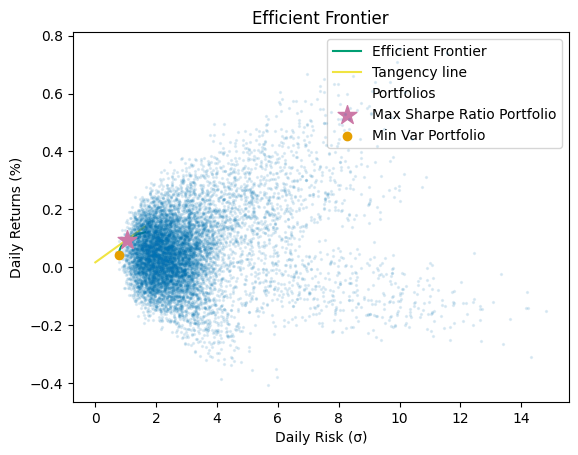

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Daily Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [28]:
annualized_optimum_return = ((1 + opt_return / 100) ** 252 - 1) * 100
annualized_optimum_risk = opt_risk * np.sqrt(252)
print(annualized_optimum_return, annualized_optimum_risk)

27.22759455348738 16.516753109411002


### Write an HDF5 file with everything needed to regenerate plot

In [29]:
portfolio_optimization_plot_data_filename = os.path.join(
    "output", "portfolio_optimization_plot_data.h5"
)
with h5py.File(portfolio_optimization_plot_data_filename, "w") as hf:
    efficient_frontier_group = hf.create_group("efficient_frontier")
    tangency_line_group = hf.create_group("tangency_line")
    simulated_portfolios_group = hf.create_group("simulated_portfolios")
    max_sharpe_ratio_group = hf.create_group("max_sharpe_ratio")
    min_var_portfolio_group = hf.create_group("min_var_portfolio")
    efficient_frontier_group.create_dataset("xs", data=optimized_risks)
    efficient_frontier_group.create_dataset("ys", data=target_returns)
    tangency_line_group.create_dataset("xs", data=tangency_xs)
    tangency_line_group.create_dataset("ys", data=tangency_ys)
    simulated_portfolios_group.create_dataset("xs", data=simulated_risks)
    simulated_portfolios_group.create_dataset("ys", data=simulated_returns)
    max_sharpe_ratio_group.create_dataset("xs", data=[opt_risk])
    max_sharpe_ratio_group.create_dataset("ys", data=[opt_return])
    min_var_portfolio_group.create_dataset("xs", data=[min_var_risk])
    min_var_portfolio_group.create_dataset("ys", data=[min_var_return])
print(f"Saved {portfolio_optimization_plot_data_filename}")

Saved output/portfolio_optimization_plot_data.h5


In [30]:
load_dotenv()
s3u = S3Uploader()

space_name = os.getenv("PORTFOLIO_OPTIMIZATION_SPACE_NAME")
s3u.upload_file(
    portfolio_optimization_plot_data_filename,
    space_name,
    "portfolio_optimization_plot_data.h5",
)

Upload of portfolio-optimization/portfolio_optimization_plot_data.h5 successful!


### Upload metadata about the plot for the front end UI

In [31]:
metadata = {
    "date_updated": {
        "date_from": str(date_from.date()),
        "date_to": str(date_to.date()),
    },
    "tickers": tdm.tickers,
    "risk_free_rate": risk_free_rate_data,
    "optimum_portfolio": {
        "annualized_return": float(annualized_optimum_return),
        "risk": float(annualized_optimum_risk),
        "weights": best_weights_pct_dict
    }
}

metadata_filename = os.path.join("output", "optimization_metadata.yml")
with open(metadata_filename, "w") as f:
    yaml.dump(metadata, f, default_flow_style=False)

s3u.upload_file(
    metadata_filename,
    space_name,
    "optimization_metadata.yml",
)

Upload of portfolio-optimization/optimization_metadata.yml successful!
